In [1]:
# Import packages needed.
import numpy as np
import random
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import collections
import tqdm
from numba import jit
from numba import njit, prange
import time
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
# Poisson spike train generation.
def inhomo_PoissonSpikeTrain(dt,T,rx,Total_time):
    rand_unis = np.random.uniform(0,1,(1,len(Total_time)))
    num_spikes = 0
    spikes_x = np.zeros_like(Total_time)
    spike_time_x = np.zeros((int(T*10**9)))
    for i in range(len(Total_time)):
        prob = rx[i] * dt # rx is time-dependent rate.
        if (prob > rand_unis[0,i]):
            spike_time_x[num_spikes] = Total_time[i]
            spikes_x[i] = 1
            num_spikes += 1
        else:
            spikes_x[i] = 0
    spike_time_x = spike_time_x[0:num_spikes]
    return spike_time_x, spikes_x

In [3]:
def EulerMethod_poisson_input_balanced(spikes_x1,spikes_x2,u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time):
    nspike = 0
    maxns=round(T*10**9); # max numbers of spikes
    s = np.zeros((1,maxns))
    u = np.zeros_like(Total_time)
    u_saved = np.zeros_like(Total_time)
    v = np.zeros_like(Total_time)
    alpha_spikes = 0
    
    for i in range(len(Total_time)-1): 

        # Euler update to u - mem pot
        u[i+1] = u[i] + (dt/tau_m)*(-u[i] - R*v[i] + w * R * spikes_x1[i] +  w * R * spikes_x2[i] )
                   
        # Euler update to v - adap var
        v[i+1] = v[i] + (dt/tau_v)*(a*u[i] - v[i] + b*tau_v*alpha_spikes)

        # If there are spikes
        if(u[i+1]>=u_thres):
            s[0,nspike]=Total_time[i]       

            # Update cumulative number of spikes
            nspike+=1
        
            # This makes plots of u(t) look better.
            # All action potentials reach u_thres exactly. 
            u_saved[i+1]=u_thres

            # Reset mem pot.
            u[i+1]=u_rest
            
            alpha_spikes = 1
        else:
            alpha_spikes = 0
            u_saved[i+1]=u[i+1]

    s=s[0,0:nspike] # Get rid of padding in s
    
    return u, u_saved, v, s

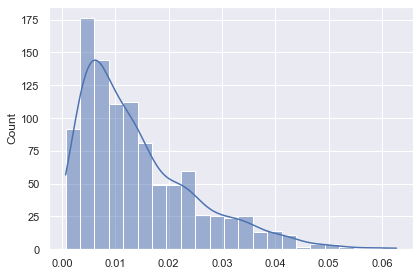

In [6]:
# Total_time  for sim
T = 500 / 10**3 # secs 
# Total_time discretization
dt = 0.01 / 10**3 # sec
# Number of Total_time bins
Total_time=np.arange(dt,T+dt,dt)

# Neuron parameters
u_rest = 0 / 10**3 # Volts
u_thres = 20 / 10**3 # Volts
tau_m = 10 / 10**3 # sec
tau_v = 100 / 10**3 # sec
R = 500 * 10**6 # Ohms

# Adaptation parameters
Num_synapses = 10**4
w = Num_synapses * 1 / 10**12 # Amps
a = 1 * 10**(-9) # S
b = 1000 * 10**(-12) *10**3 # Amps 


# Input 
I = np.zeros_like(Total_time)
start_stim = 0
end_stim = T
I[int(start_stim//dt):int(end_stim//dt)] = 0

# Inhomogeneous rate for Poisson spike trains
rx_e =  500 * (np.ones_like(Total_time)) # Hz

# Inhomogeneous rate for Poisson spike trains
rx_i =  500 * (np.ones_like(Total_time)) # Hz


np.random.seed(10)

sp_times = np.zeros(1)

while len(sp_times) < 1000:
    # Exc input
    spike_time_x_e, spikes_x_e = inhomo_PoissonSpikeTrain(dt,T,rx_e,Total_time)
    #Inh input
    spike_time_x_i, spikes_x_i = inhomo_PoissonSpikeTrain(dt,T,rx_i,Total_time)

    u, u_saved, v, s = EulerMethod_poisson_input_balanced(spikes_x_e,spikes_x_i,
                                             u_rest,u_thres,dt,tau_m,tau_v,R,w,a,b,T,Total_time)
    s = s + sp_times[-1]
    sp_times = np.append(sp_times,s)
    

ISIs = np.diff(sp_times)
pro = pd.DataFrame(ISIs)
fig = plt.figure()
pro_hist = sns.histplot(ISIs, kde=True)
# plt.title('Histogram of expected times')
plt.tight_layout()

In [7]:
fig = pro_hist.get_figure()
fig.savefig('2b.pdf',dpi=1200)